In [1]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### 1. (40pts) Define functions

### 2. Split data

In [2]:
# Reading the training data
data_train = pd.read_csv('ex4_train.csv', sep=",", encoding='utf-8', header='infer')
df_train = data_train.drop('Unnamed: 0',axis=1)
m = df_train.shape[0]

y_train = pd.DataFrame(df_train['y'])
X_train = df_train.drop(['y'], axis=1)

    y
25  7


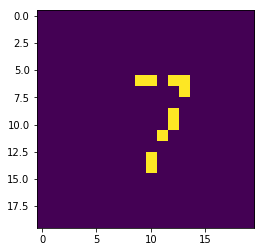

In [17]:
# Reading the test data
data_test = pd.read_csv('ex4_test.csv', sep=",", encoding='utf-8', header='infer')
df_test = data_test.drop('Unnamed: 0',axis=1)
m = df_test.shape[0]

y_test = pd.DataFrame(df_test['y'])
X_test = df_test.drop(['y'], axis=1)

# Plot the selected pixel
num = 25
pixels = np.array(X_test[num:num+1], dtype='uint8')
print(y_test[num:num+1])
pixels = pixels.reshape((20, 20)).T
plt.imshow(pixels)
plt.show()

### 3. Define number of neurons in each layer

In [ ]:
inputLayerSize = X_train.shape[0]
hiddenLayers = 2
hiddenLayerSizes = [100,40]
outputLayerSize = 10